In [1]:
# Marcin Damek, M.Cem Eriş, Mehmet Sezer, Recep O. Yıldız
# {damek20, erismu, sezer20, yildizr} @itu.edu.tr

# ITU BLG 549E Graph Theory and Algorithms Project

# Reference Metadata: 
# https://snap.stanford.edu/data/bigdata/amazon/amazon-meta.txt.gz

# Project Directory: 
# https://github.com/mumtazcem/GraphProject

# *****************************************************************************
# IMPORTANT NOTE:

# The Amazon Product Co-Purchasing Network Metadata Dataset in [1] has
# 548552 Products, 7781990 Reviews and 15010575 lines of data which is
# in total 977.5 MB.

# Due to its huge size, it takes nearly 40 minutes of parsing in a regular
# laptop. Therefore we decided to put parser code in a different Jupyter
# Notebook File named: amazon_metadata_parser.ipynb

# In order to save time to run this Jupyter Notebook file, the parsed data
# is stored in csv format. If there is a need to run the code from scratch
# please follow the steps below

# 1. Download the metadata [1] and save it in the same directory with the
#    Jupyter Notebook File named: amazon_metadata_parser.ipynb.
# 2. It creates all the matrices to run the analyzer and also images required
#    for the markdown cells of this file.
# 3. If the other products are desired for analysis, the product types 
#    should be changed.
# 4. After the successful execution of the amazon_metadata_parser.ipynb,
#    this Jupyter Notebook file is ready to be run.
# *****************************************************************************

import numpy as np
import networkx as nx
import networkx.algorithms.community as nx_comm
import matplotlib.pyplot as plt
import random
import pprint

# 1. Graph Datasets
### (1) Present your graphs G1 and G2 (number of nodes, edges, what a node and edge denote).
#### Selected Graphs
SNAP (Stanford Network Analysis Project) Amazon Product Co-Purchasing Network Metadata Dataset is used in this project. This metadata can be accessed via reference [2]. <br>

TODO: We want to find the popular products in videos and DVDs seperately.

Due to big size of products given below in numbers, Videos and DVDs are utilized. We have chosen "Videos" for Graph G1 and "DVDs" for Graph G2.

|Graphs      |Nodes |Edges|
|:-----------|:----:|----:|
|G1 (Videos) |26131 |16211|
|G2 (DVDs)   |19828 |39575|

The node degree distributions of both graphs are given below.

* The Node Degree Distribution of Graph G1
![degree_dist_G1](image_files/degree_dist_G1.png)

* The Node Degree Distribution of Graph G2
![degree_dist_G2](image_files/degree_dist_G2.png)

Since the number of nodes and edges are relatively high, it is decided to <b>remove the nodes with less than a designated node degree</b>. Therefore, the optimized graphs have the following features.

|Graphs      |Nodes |Edges|Threshold Node Degree|
|:-----------|:----:|:---:|:-------------------:|
|G1 (Videos) |453   |632  |13                   |
|G2 (DVDs)   |658   |818  |16                   |

#### Node and Edge Representation
Each product in the metadata <b>creates a node</b> in the graphs. For the clear understanding of the edge representation, the metadata representation and its fields are given below.


|Field       |Explanation |
|:-----------|:-----------|
|Id          |Product Identification Number|
|ASIN        |Amazon Standard Identification Number [3]|
|Title       |Name/Title of The Product|
|Group       |Product Group (Book, DVD, Video or Music)|
|Salesrank   |Amazon Salesrank|
|Similar     |ASINs of Co-purchased Products (People who buy X also buy Y)|
|Categories  |Location in Product Category Hierarchy to Which the Product Belongs (Separated By Pipe Character, Category ID in [])|
|Reviews     |Product Review Information: Time, User ID, Rating, Total Number of Votes on the Review, Total Number of Helpfulness Votes (Note)|

* Note: How many people found the review to be helpful?

One of the products in the metadata is given as an example:

<b>Id</b>: 123499<br>
<b>ASIN</b>: 6304812663<br>
<b>title</b>: Spice Girls - Girl Power (Live in Istanbul)<br>
<b>group</b>: Video<br>
<b>salesrank</b>: 19875<br>
<b>similar</b>: 5  6305212139  6304683235  0767808673  B00000JQV6  6305112401<br>
<b>categories</b>: 7<br>

    |[139452]|VHS[404272]|Genres[404274]|Music Video & Concerts[133]|Other Music[511482]|British[169252]
    ...
<b>reviews</b>: total: 44  downloaded: 44  avg rating: 4.5<br>

    1998-3-25  customer:  ATVPDKIKX0DER  rating: 5  votes:   0  helpful:   0
    1998-4-11  customer:  ATVPDKIKX0DER  rating: 5  votes:   0  helpful:   0
    1998-4-23  customer:  ATVPDKIKX0DER  rating: 5  votes:   0  helpful:   0
    ...

For edge representation "similar" field is used as an edge between two products. If there is a video which has a similar ASIN number which refers to an other type of product, it is ignored. The weight of an edge is assigned to a positive number by <b><u>summing up the total votes given to both of the products</u></b>. An example for the edge weight calculation is given below.
 
![Edge General Image](image_files/image_edges_general.png)

### (2) Display the adjacency matrices of both graphs. 

* Video Graph (G1) Adjacency Matrix
![AdjMatrixG1Raw](image_files/AdjMatrixG1Raw.png)

* DVDs Graph (G2) Adjacency Matrix
![AdjMatrixG2Raw](image_files/AdjMatrixG2Raw.png)

#### Colorbar is utilised in order to increase the perception of the adjacency matrices.

* Video Graph (G1) Adjacency Matrix with Enhanced Colorbar
![AdjMatrixG1VMax1](image_files/AdjMatrixG1VMax1.png)

* DVDs Graph (G2) Adjacency Matrix with Enhanced Colorbar
![AdjMatrixG2VMax1](image_files/AdjMatrixG2VMax1.png)

* Zoomed Video Graph (G1) Adjacency Matrix with Enhanced Colorbar
![AdjMatrixG1VMax1Zoomed](image_files/AdjMatrixG1VMax1Zoomed.png)

* Zoomed DVDs Graph (G2) Adjacency Matrix with Enhanced Colorbar
![AdjMatrixG2VMax1Zoomed](image_files/AdjMatrixG2VMax1Zoomed.png)

### (3) Plot the node degree distributions of both graphs in an overlaid manner.

* The Node Degree Distributions of both Graph G1 and G2
![g1_g2_distr_overlaid](image_files/g1_g2_distr_overlaid.png)

# 2. Graph Theory Principle

### (1) Present the mathematical principle or concept to explore.

Two concepts are utilised in this project. Therefore it is aimed to explore whether the nodes with high PageRank Centralities are the member of the crowded modules.

#### PageRank Centrality

PageRank centrality is derived from eigenvector centrality in which the in-degree of a node is examined as well as the number of connection of a node and its neighbors [4]. PageRank Centrality is utilised in order to find the central products in the given graphs.

#### Girvan-Newman Algorithm
In order to calculate the modules in the graphs the Girvan-Newman Algorithm is utilised. With Girvan-Newman Algorithm, the graphs are decomposed into the modules with the highest modularity.

### (2) Include a figure illustrating how it works on small graphs.

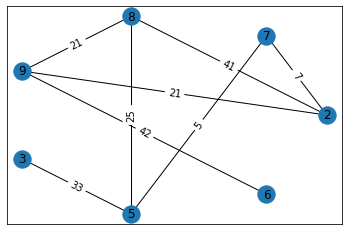

PageRank Centrality Values for Each Node
{2: 0.16859921145913553,
 3: 0.10157303162062115,
 5: 0.17420624000334525,
 6: 0.10599962087901003,
 7: 0.05331577573542032,
 8: 0.2027359733027304,
 9: 0.19357014699973732}

Girvan-Newman Algorithm is applied to Random Graph

The best modularity value of Random Graph : 0.4753086419753087
Number of connected components (modules): 5 

Module Number and its Elements:
Module 1 : 2 
Module 2 : 7 
Module 3 : 8 9 
Module 4 : 3 5 
Module 5 : 6 

End of GirvanNewmanAlgorithm


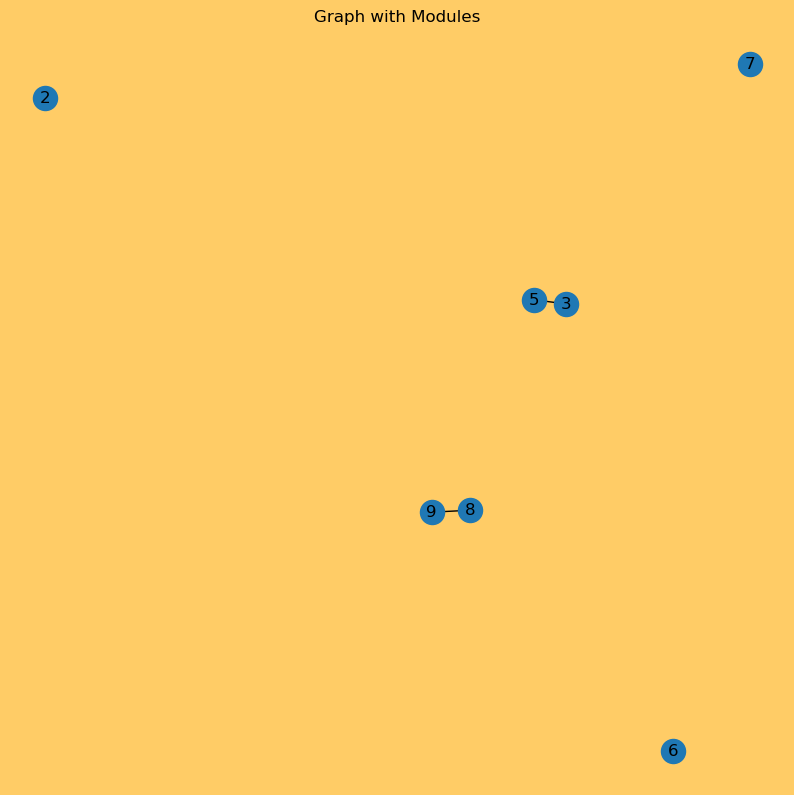

In [2]:
def RandomAdjacencyMatrix(n, p):
    M = np.zeros((n,n), dtype=np.uint8)
    for i in range(n):
        for j in range(i+1, n):
            if np.random.rand() < p:
                M[i,j], M[j, i] = 1, 1
    return M

def RandomGraph(n, p, startw, stopw):
    '''
    Creates a random networkx undirected, unweighted graph
    
    Inputs:
        n: number of nodes in graph
        p: probability of an edge being included
        startw: start value for weight
        stopw: stop value of weight
        
    Outputs:
        M: Adjacency matrix as numpy array
        G: nx Graph
        
    '''
    M = RandomAdjacencyMatrix(n, p)
    edges = np.transpose(np.where(M==1))
    
    G = nx.Graph()
    for i in range(edges.shape[0]):
        G.add_edge(edges[i, 0], edges[i, 1], weight = random.randrange(startw, stopw))
    
    return G, M

def VisualizeGraph(G):
    pos = nx.circular_layout(G)
    nx.draw_networkx(G, pos)
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
    plt.show()

def pagerank_centrality(G, alphaVal, max_iteration):
    return nx.pagerank(G, alpha = alphaVal, weight = "weight", max_iter = max_iteration)
    
'''
Girvan-Newman Algortihm Steps:
1. Calculate the betweenness centrality of each edge in graph G
2. Remove the edge with the highest betweenness centrality. Choose randomly in case same score occurs.
3. Recalculate the betweenness centrality of all remaining edges
4. Repeat steps 2 and 3 until no edges remain.
'''

# For step 1 we need to find the edge with highest betweenness centrality 
def EdgeWithHighBetweennessC(G):
    '''
    Parameters
    ----------
    G : A NetworkX graph.

    Returns
    -------
    node_x, node_y : Node_x-Node_y edge with highest betweenness centrality.
    '''

    if (G.number_of_edges == 0):
        return 0, 0
    
    else:
        edgetuple = nx.edge_betweenness_centrality(G).items()    

        # We need to find the highest value, therefore we should sort the tuples
        sortedEdgeTuple = sorted(edgetuple, key = lambda x:x[1], reverse = True)

        return sortedEdgeTuple[0][0][0], sortedEdgeTuple[0][0][1]

# For step 2 we need to remove the edge with highest betweenness centrality
def RemoveEdgeWHBWC(G):
    '''
    Notes
    -----
    RemoveEdgeWHBWC
    Remove the edge with highest betweenness centrality
    
    Parameters
    ----------
    G : A NetworkX graph.

    Returns
    -------
    G : A NetworkX graph with an edge with highest betweenness centrality is removed.
    '''
    x, y = EdgeWithHighBetweennessC(G)
    
    # Remove the edge with highest betweenness centrality
    G.remove_edge(x, y)
    # print("Remove Edge:", x, y, "# Edges:", G.number_of_edges())
    
    return G
    
def ModularityValue(G):
    '''
    Parameters
    ----------
    G : A NetworkX graph.

    Returns
    -------
    modularity_value : Modularity value of the given graph.
    '''
    if (G.number_of_edges() == 0):
        return 0
    
    else:
        modularity_value = nx_comm.modularity(G, nx_comm.label_propagation_communities(G))
        return modularity_value

def NumberOfConnectedComponents(G):
    '''
    Parameters
    ----------
    G : A NetworkX graph.

    Returns
    -------
    nu_connected_components : Number of connected components of the given graph.
    '''
    nu_connected_components = nx.number_connected_components(G)
    return nu_connected_components

def GirvanNewmanAlgorithm(G, gName):
    print("\nGirvan-Newman Algorithm is applied to", gName)
    
    # Create a graph with the best modularity components
    bestGraph = nx.empty_graph()
    
    # Calculate and keep the modularity value
    modularity = ModularityValue(G)
    modularity_best = modularity
    components_best = list(nx.connected_components(G))
    
    # Run the algorithm till the last edge exists
    while (nx.number_of_edges(G) > 0):
        
        # Run the loop till get a new component
        given_nu_Connected_Components = NumberOfConnectedComponents(G)
        while (given_nu_Connected_Components == NumberOfConnectedComponents(G)):
            RemoveEdgeWHBWC(G)
        
        # Since we get new a component, we can calculate the modularity
        # and compare it with the best modularity found so far
        modularity_current = ModularityValue(G)
        
        # Determine the best modularity
        if (modularity_current > modularity_best):
            modularity_best = modularity_current
            components_best = list(nx.connected_components(G))
            bestGraph = nx.Graph(G)
        
    if (modularity_best == modularity):
        print("\nWe cannot apply Girvan-Newman Algorithm to graph", gName, "It only has one module.")
        print("Modularity Value is:", modularity_best)
    else:
        print("\nThe best modularity value of", gName, ":", modularity_best)
        print("Number of connected components (modules):", len(components_best), "\n")
        print("Module Number and its Elements:")
        
        i = 0
        for row in components_best:
            i = i + 1
            print("Module", i, ":", end = ' ')
            for val in row:
                print(val, end = ' ')
            print()
            
    print("\nEnd of GirvanNewmanAlgorithm")
    return bestGraph

def DrawGraph(G, NetworkData, size):
    '''
    Draws the given networkx graph, with given name and size
    
    Parameters:
        G: Networkx Graph
        NetworkData : Name of the graph printed on the drawing.
        size: Image size of the graph
        
    Returns:
        None.
    '''
    plt.figure(num=None, figsize=(size, size), dpi=100, facecolor='#FFCC66')
    plt.axis('off')
    plt.title(NetworkData)

    # Define layout for the graph drawing
    pos = nx.spring_layout(G)
    nx.draw_networkx(G)
    plt.show()  

def ShowPageRank(G, alphaVal, max_iteration):
    results = pagerank_centrality(G, alphaVal, max_iteration)
    print("PageRank Centrality Values for Each Node")
    pprint.pprint(results)

# n : Number of nodes    
n = 10
p = 0.2
strtw = 1
stopw = 50

max_iteration = 1000
alphaVal = 0.8 
image_size = 10

G, M = RandomGraph(n, p, strtw, stopw)
VisualizeGraph(G)

ShowPageRank(G, alphaVal, max_iteration)

Gtemp = G.copy()
Gtemp = GirvanNewmanAlgorithm(Gtemp, "Random Graph")
DrawGraph(Gtemp, "Graph with Modules", image_size)

### (3) Formalize the principle mathematically and present your mathematical symbols and equations with comments and explanations.

TODO : Girvan-Newman Algorithm -> to decompose the network into a number of modules so that it has the highest modularity.

TODO : Pagerank

# 3. The R Space

### (1) Define R between two graph-driven metrics or properties P1 and P2 to better investigate the graph theory principle/concept you selected in Section II. Justify your rationale for exploring such relationship.

TODO: P1 and P2 results can be get from the temp file.

TODO: Morphospace results will come here.

### (2) Simulate n1 = 100 random graphs derived from G1 with same node strength distribution.

TODO: Finish

### (3) Simulate n2 = 100 random graphs derived from G2 with same node strength distribution. Detail the simulation strategy.

TODO: Finish

### (4) For each anchor graph Gi, plot its node strength distribution overlaid with that of the simulated graphs from Gi. 

TODO: Finish

### (5) Plot the anchor graphs in the R space (as star) and the simulated graph populations in dots. For a better visualization, use two different colors.

TODO: Finish

# 4. Result Interpretation and Discussion
### Discuss and interpret the simulated graph behavior in the R space. Compare both simulated datasets and anchor graphs and derive conclusions.

TODO: Finish

## References

[1] “Amazon Product Metadata and Reviews from Summer 2006.” [Online]. Available: https://snap.stanford.edu/data/bigdata/amazon/amazon-meta.txt.gz. [Accessed: 31-Jan-2021].<br>
[2] “Amazon Product Co-purchasing Network Metadata.” [Online]. Available: https://snap.stanford.edu/data/amazon-meta.html. [Accessed: 31-Jan-2021].<br>
[3] “What are UPCs, EANs, ISBNs. and ASINs?” [Online]. Available: https://www.amazon.com/gp/seller/asin-upc-isbn-info.html. [Accessed: 31-Jan-2021].<br>
[4] Page, Lawrence and Brin, Sergey and Motwani, Rajeev and Winograd, Terry (1999) The PageRank Citation Ranking: Bringing Order to the Web. Technical Report. Stanford InfoLab.<br>
[5] Girvan M. and Newman M. E. J., Community structure in social and biological networks, Proc. Natl. Acad. Sci. USA 99, 7821–7826 (2002).<br>
[6] Ghalmane, Z., El Hassouni, M., Cherifi, C. et al. Centrality in modular networks. EPJ Data Sci. 8, 15 (2019). https://doi.org/10.1140/epjds/s13688-019-0195-7